In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
results = search_images_ddg('grizzly bear')
results

(#200) ['https://4.bp.blogspot.com/-3WcCGQ1bzJI/UXcshw5QEwI/AAAAAAAAIns/gfJpUVE0FK8/s1600/Grizzly-Bear-7.jpg','https://nypost.com/wp-content/uploads/sites/2/2014/09/bear1.jpg?quality=90&strip=all&w=1236&h=820&crop=1','http://www.marketwire.com/library/MwGo/2017/3/7/11G132324/Images/3_Bears_Approach_by_Jim_Lawrence-4f4d16b51311853286570ff0d3022a81.jpg','http://cdn1.theinertia.com/wp-content/uploads/2017/09/grizz.jpg','https://s-i.huffpost.com/gen/3304294/images/o-ALASKA-BEAR-facebook.jpg','https://1.bp.blogspot.com/-422rK0Kje1E/UQW3yELFQeI/AAAAAAAAEzs/Rcg4Gniz4rU/s1600/Grizzly-Bear-2.jpg','https://wallup.net/wp-content/uploads/2019/09/124575-grizzly-bear.jpg','https://www.tsln.com/wp-content/uploads/2018/10/bears-tsln-101318-1-1240x823.jpg','https://cdn.apartmenttherapy.info/image/upload/f_auto,q_auto:eco,c_fill,g_auto,w_1500/at%2Fnews-culture%2F2019-11%2Fgrizzly-bear','https://i0.wp.com/www.commonsenseevaluation.com/wp-content/uploads/2013/08/Bear.jpg'...]

In [5]:
img1 = results[0]
img1

'https://4.bp.blogspot.com/-3WcCGQ1bzJI/UXcshw5QEwI/AAAAAAAAIns/gfJpUVE0FK8/s1600/Grizzly-Bear-7.jpg'

In [7]:
dest = 'images/grizzly.jpg'
download_url(results[0], dest)

Path('images/grizzly.jpg')

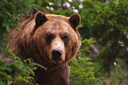

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [14]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

In [41]:
fns = get_image_files(path)
fns

(#556) [Path('bears/grizzly/b11be9a4-af83-453a-8fcb-d9b27f4e89c1.jpg'),Path('bears/grizzly/6f35ec90-c785-4393-a03b-cd90631af730.jpg'),Path('bears/grizzly/1c454fe7-f3ef-4d92-8b57-38e035a5a14f.jpg'),Path('bears/grizzly/15e87204-a9c1-4d62-a53f-6f9a76b38a5a.jpg'),Path('bears/grizzly/f09d0509-d6ba-45c3-aaa2-03aedfc7b2b5.jpg'),Path('bears/grizzly/7f73f219-8f11-4919-901e-903a503a928c.jpg'),Path('bears/grizzly/96b3ca97-76c4-4b98-9221-5244a6da491b.jpg'),Path('bears/grizzly/96c0681c-a73e-4a77-948f-472150539b5e.jpg'),Path('bears/grizzly/66d9e7ac-5ff9-4a7a-8f77-b8476392ba55.jpg'),Path('bears/grizzly/a1a83773-f87f-4b50-8fb1-8ad74007b306.jpg')...]

In [42]:
failed = verify_images(fns)
failed = failed[1:]
failed

(#0) []

In [43]:
failed.map(Path.unlink);

In [50]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

bearsdls = bears.dataloaders(path)

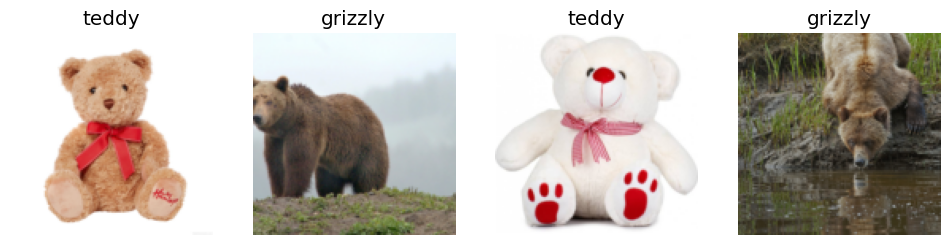

In [51]:
bearsdls.valid.show_batch(max_n=4, nrows=1)

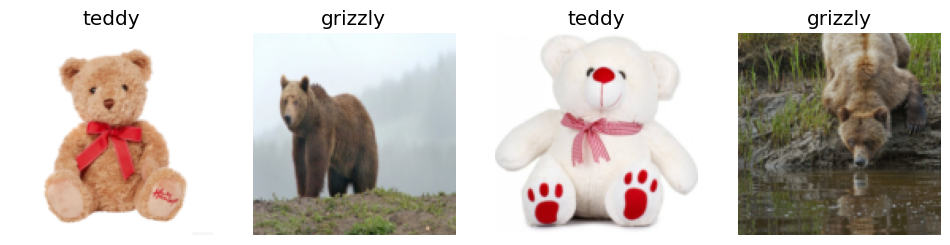

In [53]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
bearsdls = bears.dataloaders(path)
bearsdls.valid.show_batch(max_n=4, nrows=1)

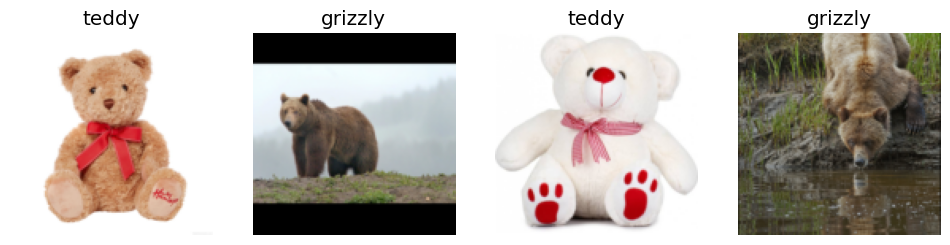

In [54]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
bearsdls = bears.dataloaders(path)
bearsdls.valid.show_batch(max_n=4, nrows=1)

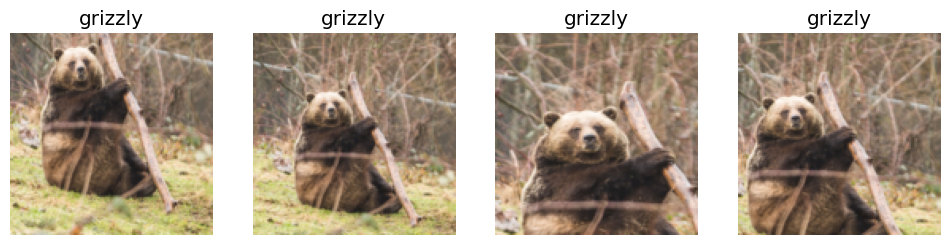

In [55]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
bearsdls = bears.dataloaders(path)
bearsdls.train.show_batch(max_n=4, nrows=1, unique=True)

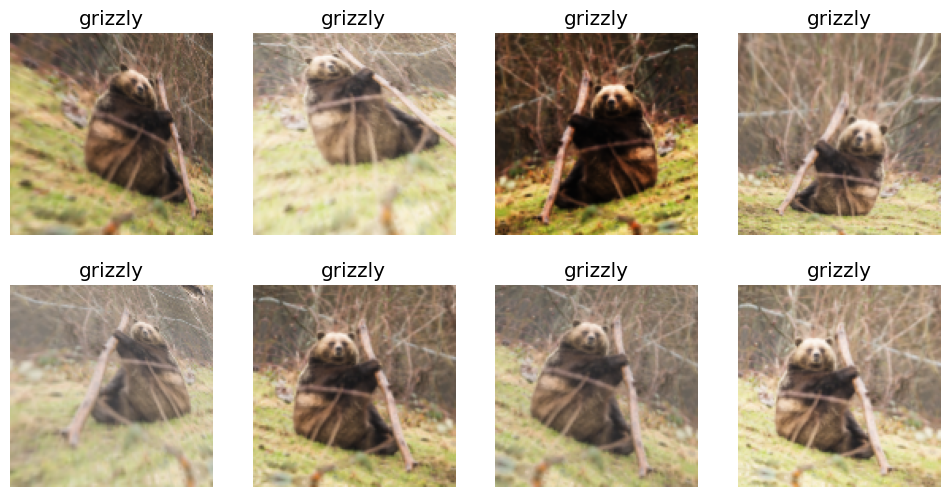

In [57]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
bearsdls = bears.dataloaders(path)
bearsdls.train.show_batch(max_n=8, nrows=2, unique=True)

In [63]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
bearsdls = bears.dataloaders(path, bs = 128)

In [64]:
learn = vision_learner(bearsdls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.607317,0.315720,0.189189,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.313274,0.097397,0.027027,00:10
1,0.244187,0.012586,0.000000,00:10
2,0.189425,0.003150,0.000000,00:09
3,0.160342,0.001803,0.000000,00:10


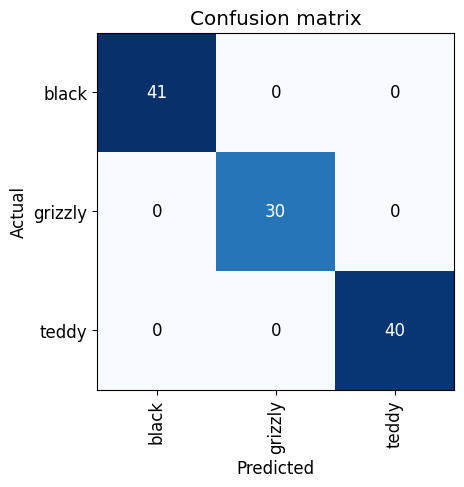

In [65]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

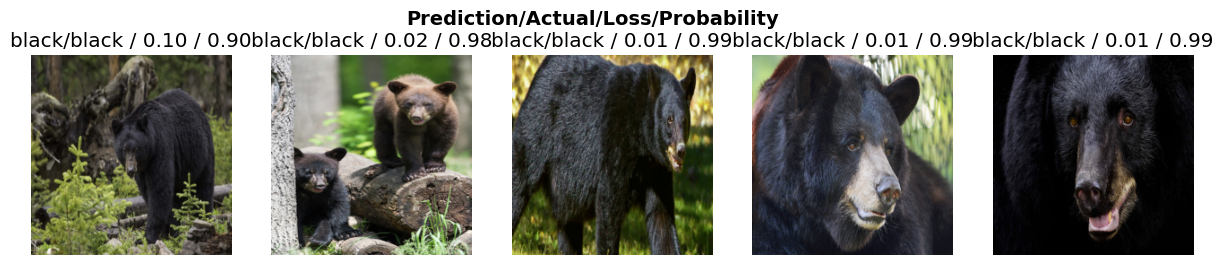

In [66]:
interp.plot_top_losses(5, nrows=1)

In [67]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [68]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [69]:
learn.export('bearmodel.pkl')

In [70]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('bearmodel.pkl')]

In [71]:
learn_inf = load_learner(path/'bearmodel.pkl')

In [72]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([2.6395e-04, 9.9935e-01, 3.8613e-04]))

In [73]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']